In [92]:
import numpy as np
import matplotlib.pyplot as plt

import jax
from functools import partial
import jax.numpy as jnp

plt.rcParams['figure.figsize'] = [12, 8]

import time
from tqdm import tqdm

from Dynamics import logistic_map, henon_map
from Kernels import ext_kernel
from Losses import rho_comp

from Optimizer import KernelSOS, flow_rho_relative
from DataManager import get_curr_data, sample_points
from utils import get_predict_func, gen_traj, predict_series, get_pred_funcs, set_seed

jax.config.update("jax_enable_x64", True)


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
# 0.0089 roughly for lr=0.3
def main_flow(y_idx):
    lr = 0.3
    num_steps = 200

    k_func = ext_kernel

    theta = np.ones(10)

    theta_star, losses = flow_rho_relative(theta, k_func, X_batch, y_batch[:, y_idx], X_sub, y_sub[:, y_idx], num_steps, lr)

    plt.plot(losses)    
    print("flow min", np.min(losses))
    
    return theta_star
    
def main_sos(y_idx):
    # Setup for Kernel SOS.
    thetas = sample_points([[0.001, 10]] * 10, 200)

    loss = lambda t: rho_comp(t, ext_kernel, X_batch, y_batch[:, y_idx], X_sub, y_sub[:, y_idx])

    fs = jnp.array([loss(t) for t in tqdm(thetas)])
    thetas = jnp.array(thetas)

    alpha0 = jnp.ones(len(fs))
    alpha0 /= jnp.sum(alpha0)
    theta_star, res, alpha = KernelSOS(alpha0, thetas, fs, loss, N=100, lmbda=0.001, eps=0.000001, sig=0.1)
    print("found min", np.min(res[:, 1]))
    print("sample min", np.min(fs))

    plt.plot(res[:, 1])
    return theta_star
    
# found min 0.005399735226533475
# sample min 0.00537916092405899

In [94]:
set_seed(0)

a = 1.4
b = 0.3
x = -0.75
y = -0.3

x_vec_0 = [x, y]



traj = jnp.array(gen_traj(henon_map(a, b), x_vec_0, 1000))

X_train = traj[:-1]
Y_train = traj[1:]

X_batch, y_batch, X_sub, y_sub = get_curr_data(X, Y, 1000, 500)



# Y.idx 0

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [03:14<00:00,  1.03it/s]


flow min 0.012739579058406392


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.47it/s]


found min 0.0067214666997972294
sample min 0.007249814496643081


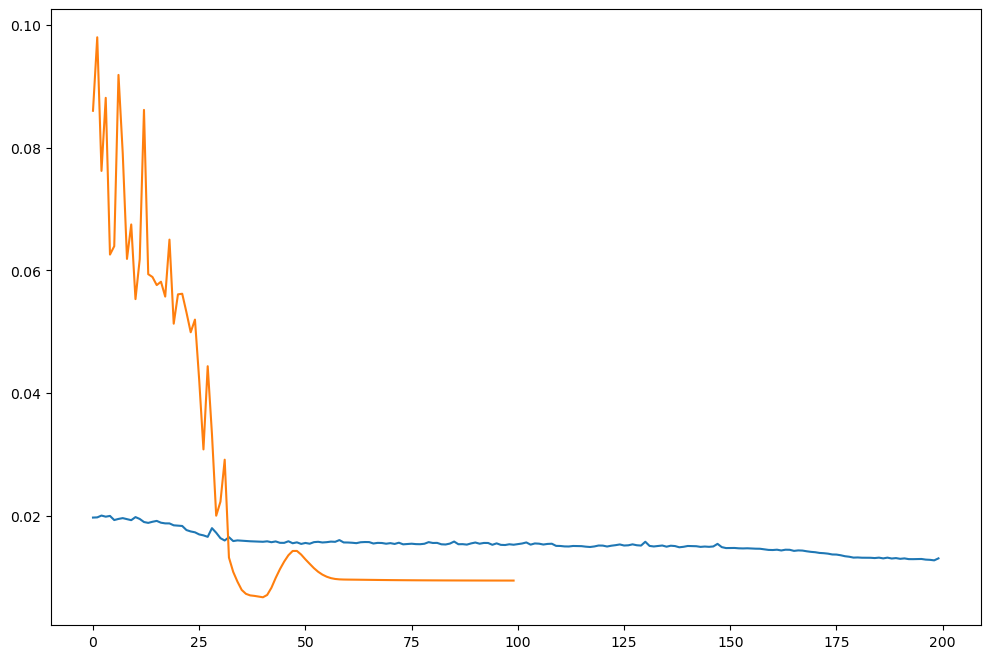

In [95]:
y_idx = 0

theta_star_flow_0 = main_flow(y_idx)
theta_star_sos_0 = main_sos(y_idx)

# Y.idx 1

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [03:18<00:00,  1.01it/s]


flow min 0.00570706867045867


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.68it/s]


found min 0.001072192780749548
sample min 0.0011845502548839537


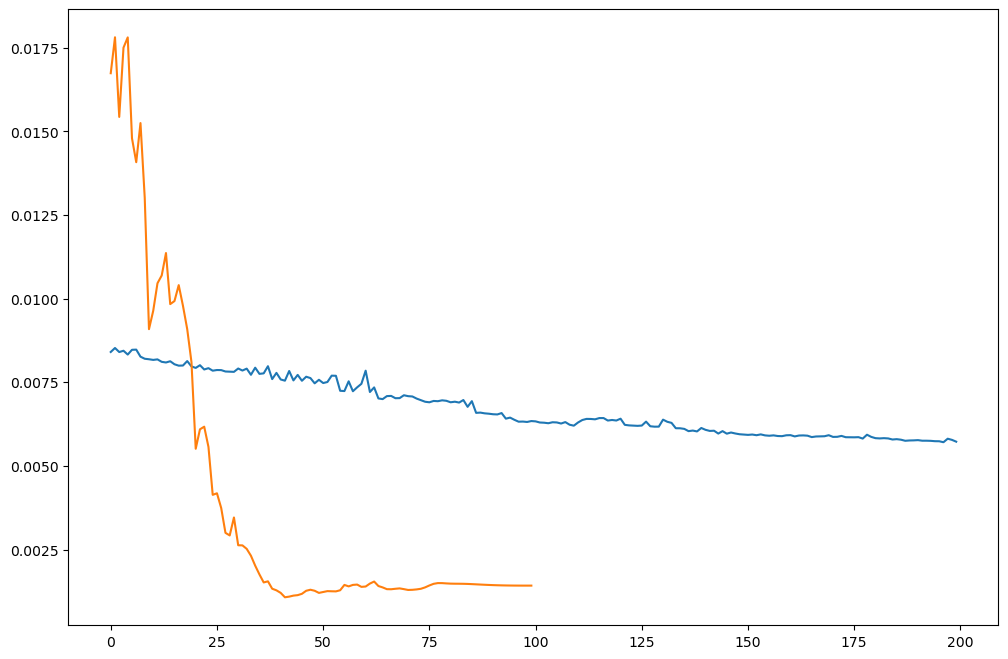

In [96]:
y_idx = 1

theta_star_flow_1 = main_flow(y_idx)
theta_star_sos_1 = main_sos(y_idx)

# Assessment

In [97]:
a = 1.4
b = 0.3

x_vec_0_test = jnp.array([0.5, 0.])
# x_vec_0_test = jnp.array([-0.75, -0.3])


traj_test = jnp.array(gen_traj(henon_map(a, b), x_vec_0_test, 1000))

X_test = traj_test[:-1]
Y_test = traj_test[1:]

In [98]:
thetas_flow = jnp.array([theta_star_flow_0, theta_star_flow_1])
thetas_sos = jnp.array([theta_star_sos_0, theta_star_sos_1])

pred_funcs_flow = get_pred_funcs(thetas_flow, ext_kernel, X_train, Y_train)
pred_funcs_sos = get_pred_funcs(thetas_sos, ext_kernel, X_train, Y_train)

# Autoregressive

In [99]:
traj_preds_flow = predict_series(pred_funcs_flow, jnp.array(x_vec_0_test), 1000)
traj_preds_sos = predict_series(pred_funcs_sos, jnp.array(x_vec_0_test), 1000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:17<00:00, 12.93it/s]


In [100]:
print("flow", np.std(np.linalg.norm((traj_test - traj_preds_flow), axis=1)))
print("sos", np.std(np.linalg.norm((traj_test - traj_preds_sos), axis=1)))

flow 0.5734875836866292
sos 0.5859389409364029


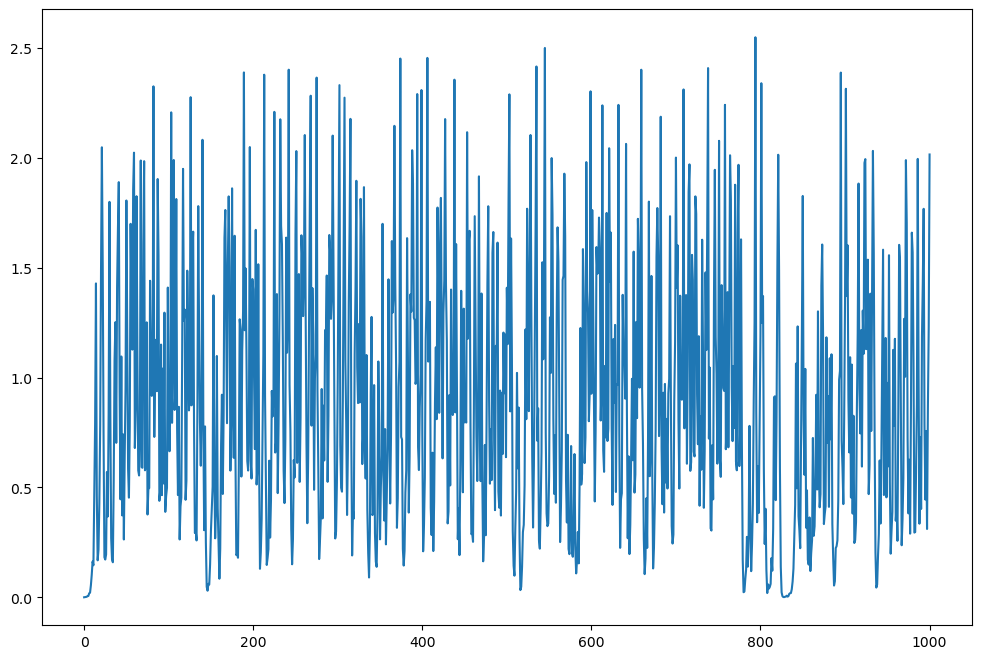

In [101]:
diff = np.linalg.norm((traj_test - traj_preds_sos), axis=1)

plt.plot(diff)
plt.show()

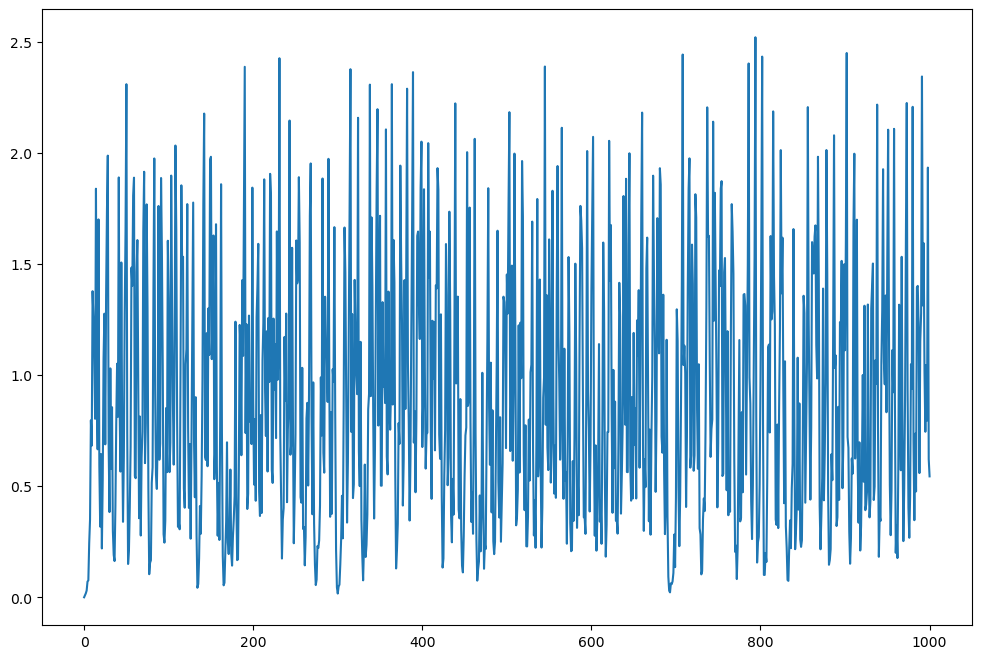

In [102]:
diff = np.linalg.norm((traj_test - traj_preds_flow), axis=1)

plt.plot(diff)
plt.show()

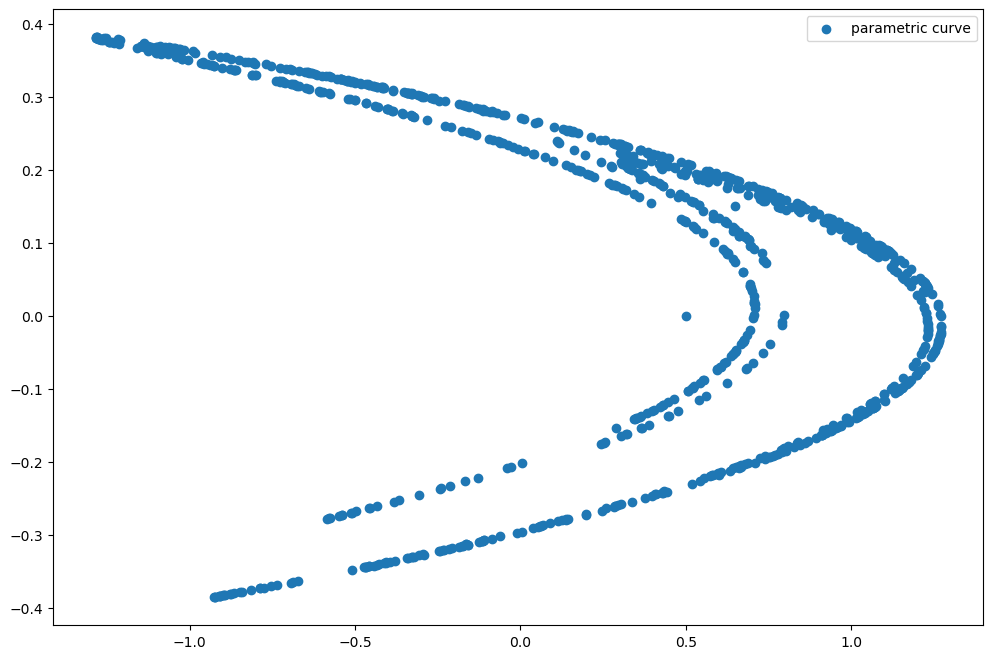

In [103]:

plt.scatter(traj_test[:, 0], traj_test[:, 1],  label='parametric curve')
plt.legend()

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


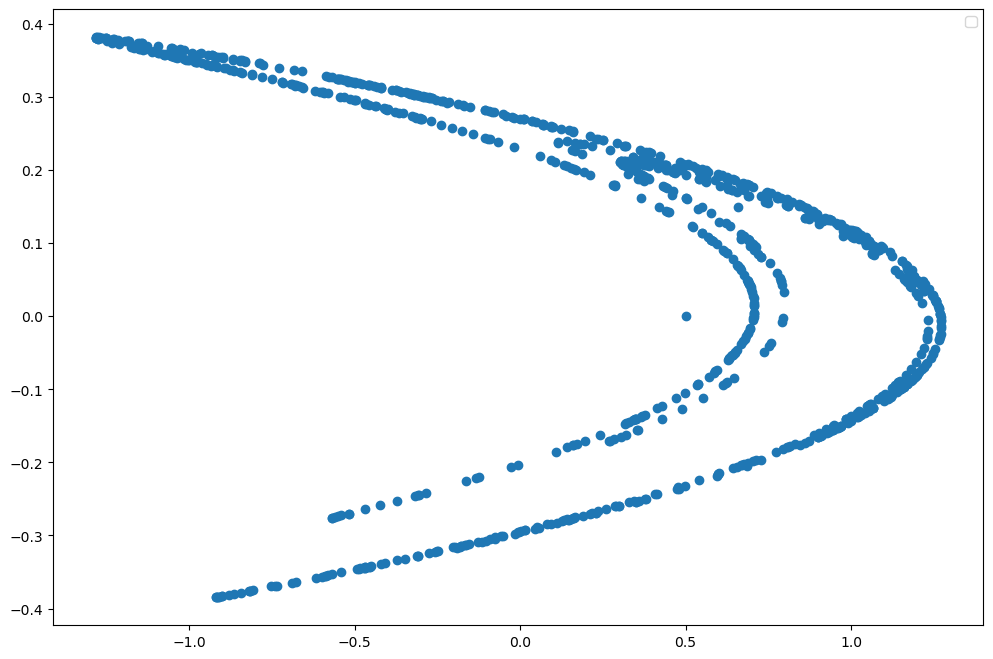

In [104]:
plt.scatter(traj_preds_flow[:, 0], traj_preds_flow[:, 1])
plt.legend()

plt.show()

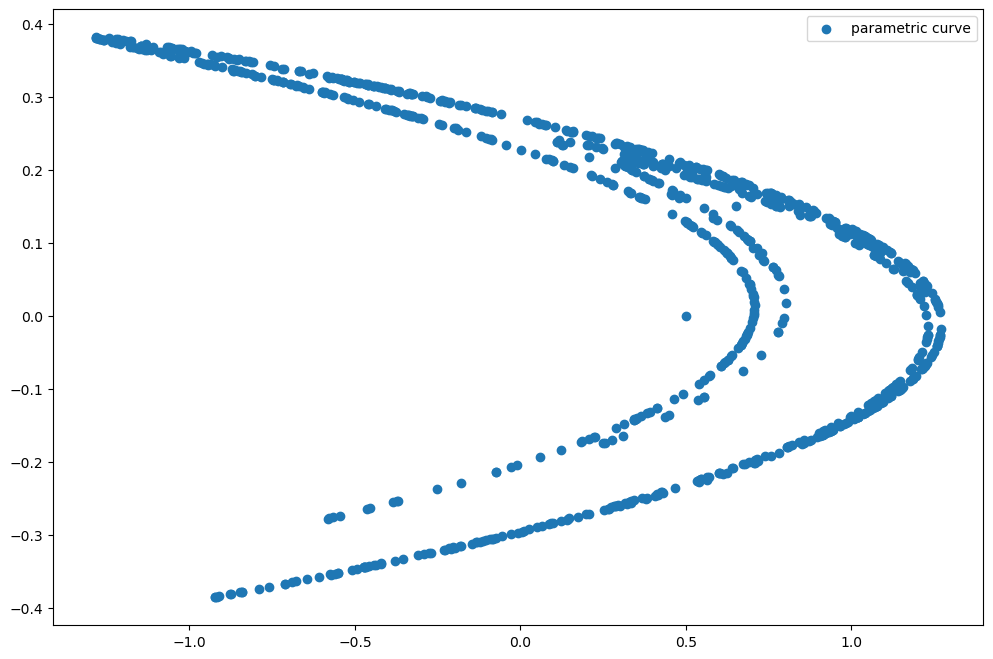

In [105]:
plt.scatter(traj_preds_sos[:, 0], traj_preds_sos[:, 1], label='parametric curve')
plt.legend()

plt.show()

# Non-autoregressive

In [106]:
res_flow = []
res_sos = []
for x in tqdm(X_test):
    curr_res_flow = []
    curr_res_sos = []
    for k in range(2):
        curr_res_flow.append(pred_funcs_flow[k](x))
        curr_res_sos.append(pred_funcs_sos[k](x))
    res_flow.append(curr_res_flow)
    res_sos.append(curr_res_sos)
    
res_flow = jnp.array(res_flow)
res_sos = jnp.array(res_sos)

print("sos", jnp.mean(jnp.linalg.norm(res_sos - Y_test, axis=1)))
print("flow", jnp.mean(jnp.linalg.norm(res_flow - Y_test, axis=1)))




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:48<00:00,  5.94it/s]


sos 0.00012607543533535244
flow 0.0003080001753353985
